In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18239850906612136387
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10814461532885806269
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [2]:
def sample_images(epoch, gan_test, gan_test_truth, past_input):
    n = 5
    test_batch = gan_test[:n,:,:,1:]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)
    fig, axs = plt.subplots(n, past_input+2, figsize=(16, 16))
    for i in range(n):
        vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
        vmin = 0
        for j in range(past_input):
            im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax,vmin=vmin)
            axs[i,j].axis('off')
            src.colorbar(im)
            axs[i,j].set_title("Frame t"+str([-past_input+1+j if j < past_input-1 else ""][0]))
        im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-2].axis('off')
        src.colorbar(im2)                
        axs[i,-2].set_title("Frame t+1")
        im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-1].axis('off')
        src.colorbar(im3)
        axs[i,-1].set_title("Prediction t+1")
    fig.savefig("Plots/epoch %d.png" % epoch)
    plt.close()
    
def noisy_d_labels(real, fake):
    # idea: https://arxiv.org/pdf/1606.03498.pdf
    batch_size = len(real)
    five_percent = int(0.05*batch_size)
    idx = np.random.randint(0, batch_size, five_percent)
    d_real = np.ones_like(real)
    d_fake = np.zeros_like(fake)
    d_real[idx] = 0
    d_fake[idx] = 1
    return d_real, d_fake

Load dataset.

In [3]:
past = 4

In [4]:
train, xval, test = src.load_datasets(past_frames=past+1)

Training data: (7500, 64, 64, 6)
Validation data: (1500, 64, 64, 6)
Test data: (1000, 64, 64, 6)


Split data to inputs and ground truth images.

In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:5], xval, test, past_frames=past+1, augment=True)

Data augmentation.
Shape of training data:  (20, 64, 64, 5) 
Shape of training truth:  (20, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 5) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 5) 
Shape of test truth:  (1000, 64, 64, 1)


Calculate optical flows between frame t-1 and t.

In [6]:
#optical flow of the augmented data for the first 2500 training images
vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

[20/20]
Optical flow map shapes: vx: (20, 64, 64, 1), vy: (20, 64, 64, 1)


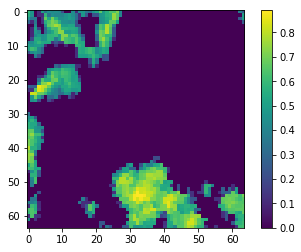

In [38]:
plt.imshow(gan_train[0,:,:,-1])
plt.colorbar()

In [29]:
d = np.concatenate((gan_train[0,:,:,-1:],vx[0],vy[0]), axis=-1)

In [30]:
d.shape

(64, 64, 3)

In [31]:
res = src.advect(d)

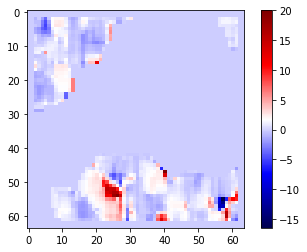

In [43]:
plt.imshow(vx[0,:,:,0],cmap="seismic")
plt.colorbar()

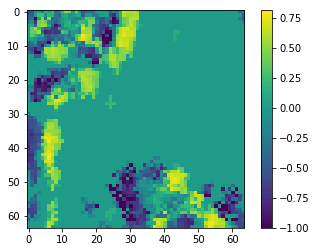

In [41]:
plt.imshow(gan_truth[0,:,:,0]- res[:,:,0])
plt.colorbar()

Make discriminator labels.

In [ ]:
batch_size=64

In [ ]:
# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
#Generator ground truths
g_real = np.ones((batch_size, 1))

In [ ]:
real, fake = noisy_d_labels(real, fake)

Make generator but don't compile.

In [ ]:
generator = src.unet((64, 64, 4), dropout=0.1, batchnorm=False)

Make discriminators and compile.

In [ ]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, 4), dropout = 0.25, batchnorm=True)
s_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

In [ ]:
t_discriminator = src.temporal_discriminator(dropout = 0.25, batchnorm=True)
t_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

Inputs and outputs of the GAN.

In [ ]:
frame_t = keras.layers.Input(shape=(64, 64, 4))
adv = keras.layers.Input(shape=(64, 64, 1))

In [ ]:
generated = generator(frame_t)
s_score = s_discriminator([frame_t, generated])
t_score = t_discriminator([adv, generated])

Freeze discriminator weights.

In [ ]:
s_discriminator.trainable = False
t_discriminator.trainable = False

Compile combined model.

In [ ]:
loss_weights=[0.3, 1, 1]

In [ ]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score, t_score])

In [ ]:
combined.compile(loss=[src.custom_loss(loss="l1"),
                       keras.losses.binary_crossentropy,
                       keras.losses.binary_crossentropy],
                 optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights)

Train x epochs.

In [ ]:
epochs = 100

In [ ]:
log = {"g_loss":[],
       "g_metric":[],
       "d_loss":[],
       "ds_loss":[],
       "ds_metric":[],
       "dt_loss":[],
       "dt_metric":[],
       "ds_loss_real":[],
       "ds_loss_fake":[],
       "ds_test_real":[],
       "ds_test_fake":[],
       "dt_loss_real":[],
       "dt_loss_fake":[],
       "dt_test_real":[],
       "dt_test_fake":[]}

In [ ]:
for epoch in range(epochs):
#DS create training batch
    s_discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    #predict next frame  
    generated_imgs = generator.predict(training_batch) 
    #train discriminator
    ds_loss_real = s_discriminator.train_on_batch([training_batch, real_imgs], real)
    ds_loss_fake = s_discriminator.train_on_batch([training_batch, generated_imgs], fake)
    #add losses
    ds_loss = 0.5 * np.add(ds_loss_real, ds_loss_fake)
    s_discriminator.trainable = False
#DT create training batch
    t_discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    aux_batch = gan_train[idx,:,:,:-1]
    #predict frame t from frame t-1 and advect
    aux_gen_imgs = generator.predict(aux_batch)
    aux_gen_imgs = np.concatenate((aux_gen_imgs, vx[idx], vy[idx]), axis=-1)
    advected_aux_gen = np.array([src.advect(sample) for sample in aux_gen_imgs])
    #advect frame t
    aux_true_imgs = training_batch[:,:,:,-1:]
    aux_true_imgs = np.concatenate((aux_true_imgs, vx[idx], vy[idx]), axis=-1)
    advected_aux_truth = np.array([src.advect(sample) for sample in aux_true_imgs])
    #predict next frame
    generated_imgs = generator.predict(training_batch) 
    #train discriminator
    dt_loss_real = t_discriminator.train_on_batch([advected_aux_truth, real_imgs], real)
    dt_loss_fake = t_discriminator.train_on_batch([advected_aux_gen, generated_imgs], fake)
    #add losses
    dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
    t_discriminator.trainable = False
    
    d_loss = 0.5 * np.add(ds_loss, dt_loss)
#G    
    
    idx = np.random.randint(0, gan_train.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    aux_batch = gan_train[idx,:,:,:-1]
    
    aux_gen_imgs = generator.predict(aux_batch)
    aux_gen_imgs = np.concatenate((aux_gen_imgs, vx[idx], vy[idx]), axis=-1)
    advected = np.array([src.advect(sample) for sample in aux_gen_imgs])

    g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, g_real, g_real])
    
    if g_loss[1] < 0.12 and loss_weights[0] > 2**(-1):
        loss_weights[0] /= 2
        combined.compile(loss=[src.custom_loss(loss="l1"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights)
    
    log["g_loss"].append(g_loss)
    log["d_loss"].append(d_loss)
    log["ds_loss_real"].append(ds_loss_real[0])
    log["ds_loss_fake"].append(ds_loss_fake[0])
    log["dt_loss_real"].append(dt_loss_real[0])
    log["dt_loss_fake"].append(dt_loss_fake[0])
    log["ds_loss"].append(ds_loss[0])
    log["ds_metric"].append(ds_loss[1])
    log["dt_loss"].append(dt_loss[0])
    log["dt_metric"].append(dt_loss[1])
    print(f"\033[1m {epoch} [Ds loss: {ds_loss[0]}, acc.: {100*ds_loss[1]}]\033[0m \n"+
          f"\033[1m {epoch} [Dt loss: {dt_loss[0]}, acc.: {100*dt_loss[1]}]\033[0m \n"+
          f"\033[1m {epoch} [G loss: {g_loss[0]}, G obj.: {g_loss[1]}, Gs bce.: {g_loss[2]}, Gt bce.: {g_loss[3]}]\033[0m")
    print(f"S: real loss: {ds_loss_real}, fake loss: {ds_loss_fake}")
    print(f"T: real loss: {dt_loss_real}, fake loss: {dt_loss_fake}")

    #print(f"test real acc.: {np.mean(d_test_real)}, test fake acc.: {np.mean(d_test_fake)}")
    if epoch%10 == 0:
        sample_images(epoch, gan_test, gan_test_truth, past)

In [ ]:
#%matplotlib notebook
plt.plot(np.array(log["g_loss"])[:,0], alpha=0.3,c="b")
plt.plot(np.array(log["d_loss"])[:,0],alpha=0.3, c="orange")

#plt.plot(np.array(log["g_loss"])[:,1], alpha=0.9,c="green", label="L1 objective")

plt.plot(src.smooth(np.array(log["g_loss"])[:,0]),c="b", label="generator")
plt.plot(src.smooth(np.array(log["d_loss"])[:,0]),c="orange", label="discriminator")
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("sGAN_training_curves_r")


## Save network weights and log

In [ ]:
def save_model_params(name, model, log, scores):
    for key in list(scores.keys()):
        log[key] = scores[key]
    np.save("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings/"+name+"/"+name, log) 
    model.save_weights("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings/"+name+"/"+name)

In [ ]:
name = "sgan_4-1"

In [ ]:
predictions = generator.predict(gan_test[:,:,:,1:])

In [ ]:
scores = src.calculate_skill_scores(predictions, gan_test_truth, gan_test, 0.3)

In [ ]:
save_model_params(name, combined, log, scores)

# Some visualisation

In [ ]:
np.mean(scores["corr_to_truth"])

In [ ]:
np.mean(scores["corr_to_input"])

In [ ]:
#%matplotlib notebook
plt.imshow(predictions[0,:,:,0], vmin=0)

In [ ]:
predictions.shape

In [ ]:
labels = s_discriminator.predict([gan_test[:,:,:,1:], gan_test_truth])

In [ ]:
np.mean(labels)

In [ ]:
#%matplotlib notebook
plt.imshow(gan_test_truth[0,:,:,0], vmin=0)

In [ ]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
    has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
    GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
    the discriminator wants to make the distance between its output for real and generated samples as large as possible.
    The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
    0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be) less than 0."""
    return K.mean(y_true * y_pred)